# (Wang, 2002) Decision making spiking model

Implementation of the paper:

- Wang, Xiao-Jing. "Probabilistic decision making by slow reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.

In [1]:
# -*- coding: utf-8 -*-
import brainpy as bp
import numpy as np
import brainmodels
import matplotlib.pyplot as plt

In [2]:
# set params
# set global params
dt = 0.05  # ms
method = 'exponential'
bp.backend.set('numpy', dt=dt)

# set network params
base_N_E = 1600
base_N_I = 400
net_scale = 5.
N_E = int(base_N_E // net_scale)
N_I = int(base_N_I // net_scale)

f = 0.15  # Note: proportion of neurons activated by one of the two stimulus
N_A = int(f * N_E)
N_B = int(f * N_E)
N_non = N_E - N_A - N_B  # Note: N_E = N_A + N_B + N_non
print(f"N_E = {N_E} = {N_A} + {N_B} + {N_non}, N_I = {N_I}")

time_scale = 1.
pre_period = 100. / time_scale
stim_period = 1000.
delay_period = 500. / time_scale
total_period = pre_period + stim_period + delay_period

N_E = 320 = 48 + 48 + 224, N_I = 80


In [3]:
# set LIF neu params
V_rest_E = -70.      # mV
V_reset_E = -55.     # mV
V_th_E = -50.        # mV
g_E = 25. * 1e-3     # uS
R_E = 1 / g_E        # MOhm
C_E = 0.5            # nF
tau_E = 20.          # ms
t_refractory_E = 2.  # ms
print(f"R_E * C_E = {R_E * C_E} should be equal to tau_E = {tau_E}")

V_rest_I = -70.      # mV
V_reset_I = -55.     # mV
V_th_I = -50.        # mV
g_I = 20. * 1e-3     # uS
R_I = 1 / g_I        # Mohm
C_I = 0.2            # nF
tau_I = 10.          # ms
t_refractory_I = 1.  # ms
print(f"R_I * C_I = {R_I * C_I} should be equal to tau_I = {tau_I}")


class LIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, R, tau):
        dvdt = (- (V - V_rest) + R * I_ext) / tau
        return dvdt

    def __init__(self, size, V_rest=0., V_reset=0.,
                 V_th=0., R=0., tau=0., t_refractory=0.,
                 **kwargs):
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        self.V = bp.backend.zeros(size)
        self.input = bp.backend.zeros(size)
        self.spike = bp.backend.zeros(size, dtype=bool)
        self.refractory = bp.backend.zeros(size, dtype=bool)
        self.t_last_spike = bp.backend.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(LIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        # update variables
        not_ref = (_t - self.t_last_spike > self.t_refractory)
        self.V[not_ref] = self.integral(
            self.V[not_ref], _t, self.input[not_ref],
            self.V_rest, self.R, self.tau)
        sp = (self.V > self.V_th)
        self.V[sp] = self.V_reset
        self.t_last_spike[sp] = _t
        self.spike = sp
        self.refractory = ~not_ref
        self.input[:] = 0.

R_E * C_E = 20.0 should be equal to tau_E = 20.0
R_I * C_I = 10.0 should be equal to tau_I = 10.0


In [4]:
# set syn params
E_AMPA = 0.            # mV
tau_decay_AMPA = 2     # ms

E_NMDA = 0.            # mV
alpha_NMDA = 0.062     # \
beta_NMDA = 3.57       # \
cc_Mg_NMDA = 1.        # mM
a_NMDA = 0.5           # kHz/ms^-1
tau_rise_NMDA = 2.     # ms
tau_decay_NMDA = 100.  # ms

E_GABAa = -70.         # mV
tau_decay_GABAa = 5.   # ms

delay_syn = 0.5        # ms


class NMDA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.15, E=0., cc_Mg=1.2,
                 alpha=0.062, beta=3.57, tau=100,
                 a=0.5, tau_rise=2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # variables
        self.s = bp.backend.zeros(self.size)
        self.x = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(NMDA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.x += bp.backend.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.s, self.x = self.integral(self.s, self.x, _t,
                                       self.tau_rise, self.tau, self.a)

        self.g.push(self.g_max * self.s)
        g_inf = 1 + self.cc_Mg / self.beta * \
                bp.backend.exp(-self.alpha * self.post.V)
        g_inf = 1 / g_inf
        self.post.input -= bp.backend.sum(self.g.pull(), axis=0) * \
                           (self.post.V - self.E) * g_inf


class AMPA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau):
        ds = - s / tau
        return ds

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # data
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.int_s = bp.odeint(f=self.derivative, method='euler')
        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        self.s += bp.backend.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.backend.sum(self.g.pull(), 0) \
                           * (self.post.V - self.E)


class GABAa(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau_decay):
        dsdt = - s / tau_decay
        return dsdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.4, E=-80., tau_decay=6.,
                 **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau_decay = tau_decay
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.backend.shape(self.conn_mat)

        # data
        self.s = bp.backend.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(GABAa, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.integral(self.s, _t, self.tau_decay)
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.s[i] += self.conn_mat[i]
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.backend.sum(g, axis=0) \
                           * (self.post.V - self.E)

In [5]:
# set syn weights (only used in recurrent E connections)
w_pos = 1.7
w_neg = 1. - f * (w_pos - 1.) / (1. - f)
print(f"the structured weight is: w_pos = {w_pos}, w_neg = {w_neg}")
# inside select group: w = w+
# between group / from non-select group to select group: w = w-
# A2A B2B w+, A2B B2A w-, non2A non2B w-
weight = np.ones((N_E, N_E), dtype=np.float)
for i in range(N_A):
    weight[i, 0: N_A] = w_pos
    weight[i, N_A: N_A + N_B] = w_neg
for i in range(N_A, N_A+N_B):
    weight[i, N_A: N_A + N_B] = w_pos
    weight[i, 0: N_A] = w_neg
for i in range(N_A + N_B, N_E):
    weight[i, 0: N_A + N_B] = w_neg
print(f"Check contraints: Weight sum {weight.sum(axis=0)[0]} \
        should be equal to N_E = {N_E}")
# weight is used only for check normalization constraints

the structured weight is: w_pos = 1.7, w_neg = 0.8764705882352941
Check contraints: Weight sum 319.9999999999997         should be equal to N_E = 320


In [6]:
# set background params
poisson_freq = 2400.            # Hz
g_max_ext2E_AMPA = 2.1 * 1e-3   # uS
g_max_ext2I_AMPA = 1.62 * 1e-3  # uS

g_max_E2E_AMPA = 0.05  * 1e-3 * net_scale
g_max_E2E_NMDA = 0.165 * 1e-3 * net_scale
g_max_E2I_AMPA = 0.04  * 1e-3 * net_scale
g_max_E2I_NMDA = 0.13  * 1e-3 * net_scale
g_max_I2E_GABAa = 1.3  * 1e-3 * net_scale
g_max_I2I_GABAa = 1.0  * 1e-3 * net_scale

In [7]:
# def neurons
# def E neurons/pyramid neurons
neu_A = LIF(N_A, monitors=['spike', 'input', 'V'])
neu_A.V_rest = V_rest_E
neu_A.V_reset = V_reset_E
neu_A.V_th = V_th_E
neu_A.R = R_E
neu_A.tau = tau_E
neu_A.t_refractory = t_refractory_E
neu_A.V = bp.backend.ones(N_A) * V_rest_E

neu_B = LIF(N_B, monitors=['spike', 'input', 'V'])
neu_B.V_rest = V_rest_E
neu_B.V_reset = V_reset_E
neu_B.V_th = V_th_E
neu_B.R = R_E
neu_B.tau = tau_E
neu_B.t_refractory = t_refractory_E
neu_B.V = bp.backend.ones(N_B) * V_rest_E

neu_non = LIF(N_non, monitors=['spike', 'input', 'V'])
neu_non.V_rest = V_rest_E
neu_non.V_reset = V_reset_E
neu_non.V_th = V_th_E
neu_non.R = R_E
neu_non.tau = tau_E
neu_non.t_refractory = t_refractory_E
neu_non.V = bp.backend.ones(N_non) * V_rest_E

# def I neurons/interneurons
neu_I = LIF(N_I, monitors=['input', 'V'])
neu_I.V_rest = V_rest_I
neu_I.V_reset = V_reset_I
neu_I.V_th = V_th_I
neu_I.R = R_I
neu_I.tau = tau_I
neu_I.t_refractory = t_refractory_I
neu_I.V = bp.backend.ones(N_I) * V_rest_I

In [8]:
# def synapse connections
## define E2E conn
syn_A2A_AMPA = AMPA(pre=neu_A, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2A_NMDA = NMDA(pre=neu_A, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_A2B_AMPA = AMPA(pre=neu_A, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2B_NMDA = NMDA(pre=neu_A, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_A2non_AMPA = AMPA(pre=neu_A, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2non_NMDA = NMDA(pre=neu_A, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_B2A_AMPA = AMPA(pre=neu_B, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2A_NMDA = NMDA(pre=neu_B, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_B2B_AMPA = AMPA(pre=neu_B, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2B_NMDA = NMDA(pre=neu_B, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_B2non_AMPA = AMPA(pre=neu_B, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2non_NMDA = NMDA(pre=neu_B, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_non2A_AMPA = AMPA(pre=neu_non, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_non2A_NMDA = NMDA(pre=neu_non, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_non2B_AMPA = AMPA(pre=neu_non, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_non2B_NMDA = NMDA(pre=neu_non, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
syn_non2non_AMPA = AMPA(pre=neu_non, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_non2non_NMDA = NMDA(pre=neu_non, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
 
                    
syn_A2A_AMPA.g_max = g_max_E2E_AMPA * w_pos
syn_A2A_NMDA.g_max = g_max_E2E_NMDA * w_pos
                    
syn_A2B_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_A2B_NMDA.g_max = g_max_E2E_NMDA * w_neg
                    
syn_A2non_AMPA.g_max = g_max_E2E_AMPA 
syn_A2non_NMDA.g_max = g_max_E2E_NMDA 
                    
syn_B2A_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_B2A_NMDA.g_max = g_max_E2E_NMDA * w_neg
                    
syn_B2B_AMPA.g_max = g_max_E2E_AMPA * w_pos
syn_B2B_NMDA.g_max = g_max_E2E_NMDA * w_pos
                    
syn_B2non_AMPA.g_max = g_max_E2E_AMPA 
syn_B2non_NMDA.g_max = g_max_E2E_NMDA 
                    
syn_non2A_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_non2A_NMDA.g_max = g_max_E2E_NMDA * w_neg
                    
syn_non2B_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_non2B_NMDA.g_max = g_max_E2E_NMDA * w_neg
                    
syn_non2non_AMPA.g_max = g_max_E2E_AMPA 
syn_non2non_NMDA.g_max = g_max_E2E_NMDA 

for i in [syn_A2A_AMPA, syn_A2B_AMPA, syn_A2non_AMPA, 
          syn_B2A_AMPA, syn_B2B_AMPA, syn_B2non_AMPA,
          syn_non2A_AMPA, syn_non2B_AMPA, syn_non2non_AMPA]:
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA
    i.E = E_NMDA


for i in [syn_A2A_NMDA, syn_A2B_NMDA, syn_A2non_NMDA, 
          syn_B2A_NMDA, syn_B2B_NMDA, syn_B2non_NMDA,
          syn_non2A_NMDA, syn_non2B_NMDA, syn_non2non_NMDA]:
    i.alpha = alpha_NMDA
    i.beta = beta_NMDA
    i.cc_Mg = cc_Mg_NMDA
    i.a = a_NMDA
    i.tau_decay = tau_decay_NMDA
    i.tau_rise = tau_rise_NMDA
    
## define E2I conn
syn_A2I_AMPA = AMPA(pre=neu_A, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2I_NMDA = NMDA(pre=neu_A, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2I_AMPA = AMPA(pre=neu_B, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2I_NMDA = NMDA(pre=neu_B, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_non2I_AMPA = AMPA(pre=neu_non, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_non2I_NMDA = NMDA(pre=neu_non, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
                    
for i in [syn_A2I_AMPA, syn_B2I_AMPA, syn_non2I_AMPA]:
    i.g_max = g_max_E2I_AMPA
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA

for i in [syn_A2I_NMDA, syn_B2I_NMDA, syn_non2I_NMDA]:
    i.g_max = g_max_E2I_NMDA
    i.E = E_NMDA
    i.alpha = alpha_NMDA
    i.beta = beta_NMDA
    i.cc_Mg = cc_Mg_NMDA
    i.a = a_NMDA
    i.tau_decay = tau_decay_NMDA
    i.tau_rise = tau_rise_NMDA

## define I2E conn
syn_I2A_GABAa = GABAa(pre=neu_I, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2B_GABAa = GABAa(pre=neu_I, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2non_GABAa = GABAa(pre=neu_I, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
for i in [syn_I2A_GABAa, syn_I2B_GABAa, syn_I2non_GABAa]:
    i.g_max = g_max_I2E_GABAa
    i.E = E_GABAa
    i.tau_decay = tau_decay_GABAa

## define I2I conn
syn_I2I_GABAa = GABAa(pre=neu_I, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2I_GABAa.g_max = g_max_I2I_GABAa
syn_I2I_GABAa.E = E_GABAa
syn_I2I_GABAa.tau_decay = tau_decay_GABAa

In [9]:
# def background poisson input
class PoissonInput(bp.NeuGroup):
    target_backend='general'
    
    def __init__(self, size, freqs, dt, **kwargs):
        self.freqs = freqs
        self.dt = dt
        
        self.spike = bp.backend.zeros(size, dtype=bool)

        super(PoissonInput, self).__init__(size=size, **kwargs)
    
    def update(self, _t):
        self.spike = np.random.random(self.size) \
                     < self.freqs * self.dt / 1000.

neu_poisson_A = PoissonInput(N_A, freqs=poisson_freq, dt=dt)
neu_poisson_B = PoissonInput(N_B, freqs=poisson_freq, dt=dt)
neu_poisson_non = PoissonInput(N_non, freqs=poisson_freq, dt=dt)
neu_poisson_I = PoissonInput(N_I, freqs=poisson_freq, dt=dt)

syn_back2A_AMPA = AMPA(pre=neu_poisson_A, post=neu_A,
                       conn=bp.connect.One2One())
syn_back2B_AMPA = AMPA(pre=neu_poisson_B, post=neu_B,
                       conn=bp.connect.One2One())
syn_back2non_AMPA = AMPA(pre=neu_poisson_non, post=neu_non,
                       conn=bp.connect.One2One())
for i in [syn_back2A_AMPA, syn_back2B_AMPA, syn_back2non_AMPA]:
    i.g_max = g_max_ext2E_AMPA
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA

syn_back2I_AMPA = AMPA(pre=neu_poisson_I, post=neu_I,
                       conn=bp.connect.One2One())
syn_back2I_AMPA.g_max = g_max_ext2I_AMPA
syn_back2I_AMPA.E = E_AMPA
syn_back2I_AMPA.tau_decay = tau_decay_AMPA
# Note: all neurons receive 2400Hz background possion inputs

In [10]:
## def stimulus input
# Note: inputs only given to A and B group
mu_0 = 40.
coherence = 25.6
rou_A = mu_0/100.
rou_B = mu_0/100.
mu_A = mu_0 + rou_A * coherence
mu_B = mu_0 - rou_B * coherence
print(f"coherence = {coherence}, mu_A = {mu_A}, mu_B = {mu_B}")

class PoissonStim(bp.NeuGroup):
    """
    from time <t_start> to <t_end> during the simulation, the neuron 
    generates a possion spike with frequency <self.freq>. however, 
    the value of <self.freq> changes every <t_interval> ms and obey 
    a Gaussian distribution defined by <mean_freq> and <var_freq>.
    """ 
    target_backend = 'general'
    
    def __init__(self, size, dt = 0., t_start=0., t_end=0., t_interval=0., 
                 mean_freq=0., var_freq=20., **kwargs):
        self.dt = dt
        self.stim_start_t = t_start
        self.stim_end_t = t_end
        self.stim_change_freq_interval = t_interval
        self.mean_freq = mean_freq
        self.var_freq = var_freq
        
        self.freq = 0.
        self.t_last_change_freq = -1e7
        self.spike = bp.backend.zeros(size, dtype = bool)
        
        super(PoissonStim, self).__init__(size=size, **kwargs)
    
    def update(self, _t):
        if _t > self.stim_start_t and _t < self.stim_end_t:
            if _t - self.t_last_change_freq \
               >= self.stim_change_freq_interval:  #change freq
                self.freq = np.random.normal(self.mean_freq, self.var_freq)
                self.freq = max(self.freq, 0)
                self.t_last_change_freq = _t
            self.spike = np.random.random(self.size) \
                         < (self.freq * self.dt / 1000)
        else:
            self.freq = 0.
            self.spike[:] = False

neu_input2A = PoissonStim(
    N_A,
    dt = dt,
    t_start=pre_period,
    t_end=pre_period + stim_period,
    t_interval=50.,
    mean_freq=mu_A,
    var_freq=10.,
    monitors=['freq'])
neu_input2B = PoissonStim(
    N_B,
    dt = dt,
    t_start=pre_period,
    t_end=pre_period + stim_period,
    t_interval=50.,
    mean_freq=mu_B,
    var_freq=10.,
    monitors=['freq'])

syn_input2A_AMPA = AMPA(pre=neu_input2A, post=neu_A,
                        conn=bp.connect.One2One())
syn_input2A_AMPA.g_max = g_max_ext2E_AMPA
syn_input2A_AMPA.E = E_AMPA
syn_input2A_AMPA.tau_decay = tau_decay_AMPA

syn_input2B_AMPA = AMPA(pre=neu_input2B, post=neu_B,
                        conn=bp.connect.One2One())
syn_input2B_AMPA.g_max = g_max_ext2E_AMPA
syn_input2B_AMPA.E = E_AMPA
syn_input2B_AMPA.tau_decay = tau_decay_AMPA

coherence = 25.6, mu_A = 50.24, mu_B = 29.759999999999998


In [11]:
# build & simulate network
net = bp.Network(
    neu_poisson_A, neu_poisson_B, 
    neu_poisson_non, neu_poisson_I,
    #bg input
    syn_back2A_AMPA, syn_back2B_AMPA, 
    syn_back2non_AMPA, syn_back2I_AMPA,
    #bg conn
    neu_input2A, neu_input2B,
    #stim input
    syn_input2A_AMPA, syn_input2B_AMPA,
    #stim conn
    neu_A, neu_B, neu_non, neu_I,
    #E(A B non), I neu
    syn_A2A_AMPA, syn_A2A_NMDA,
    syn_A2B_AMPA, syn_A2B_NMDA,
    syn_A2non_AMPA, syn_A2non_NMDA,
    syn_B2A_AMPA, syn_B2A_NMDA,
    syn_B2B_AMPA, syn_B2B_NMDA,
    syn_B2non_AMPA, syn_B2non_NMDA,
    syn_non2A_AMPA, syn_non2A_NMDA,
    syn_non2B_AMPA, syn_non2B_NMDA,
    syn_non2non_AMPA, syn_non2non_NMDA,
    #E2E conn
    syn_A2I_AMPA, syn_A2I_NMDA,
    syn_B2I_AMPA, syn_B2I_NMDA,
    syn_non2I_AMPA, syn_non2I_NMDA,
    #E2I conn
    syn_I2A_GABAa, syn_I2B_GABAa, syn_I2non_GABAa, 
    #I2E conn
    syn_I2I_GABAa
    #I2I conn
)
# Note: you may also use .add method of bp.Network to add
#       NeuGroups and SynConns to network

net.run(duration=total_period, inputs=[])

computing fr...
get fr


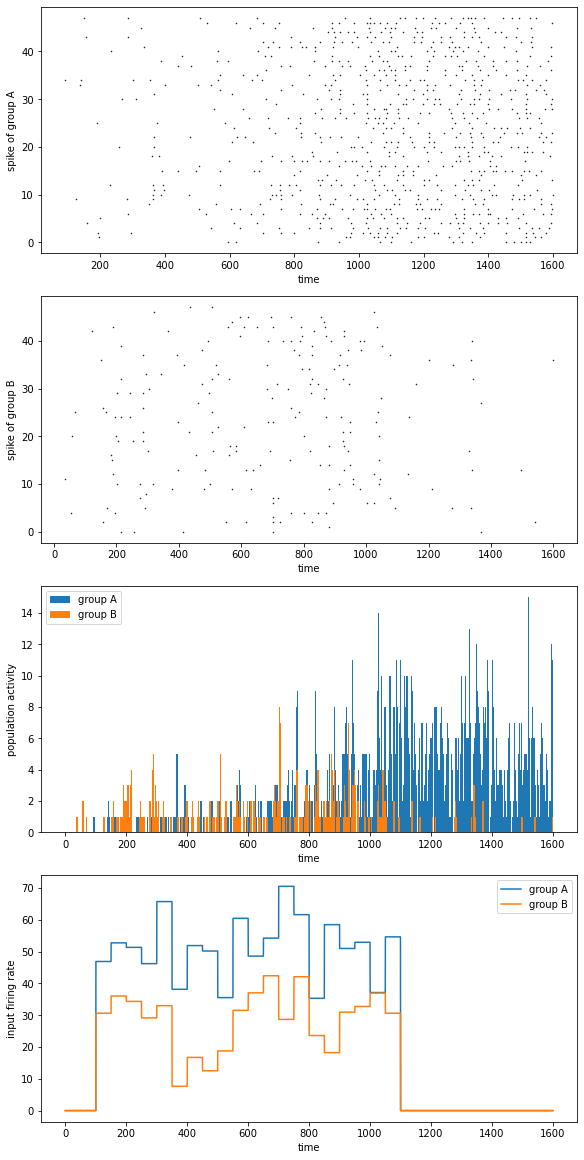

In [12]:
# visualize
def compute_population_fr(data, time_window, time_step):
    spike_cnt_group = data.sum(axis = 1)
    pop_num = data.shape[1]
    time_cnt = int(time_step // dt)
    first_step_sum = spike_cnt_group[0:time_cnt].sum(axis = 0)
    pop_fr_group = []
    for t in range(data.shape[0]):
        if t < time_cnt:
            pop_fr_group.append((first_step_sum / time_step)/pop_num)
        else:
            pop_fr_group.append(spike_cnt_group[t - time_cnt:t].sum(axis = 0))
    return pop_fr_group

fig, gs = bp.visualize.get_figure(4, 1, 4, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(net.ts, neu_A.mon.spike, 
                         markersize=1)
plt.xlabel("time")
plt.ylabel("spike of group A")
fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.ts, neu_B.mon.spike,
                         markersize=1)
plt.xlabel("time")
plt.ylabel("spike of group B")

fig.add_subplot(gs[2, 0])
print("computing fr...")
pop_fr_A = compute_population_fr(neu_A.mon.spike, time_window = 50., time_step = 5.)
pop_fr_B = compute_population_fr(neu_B.mon.spike, time_window = 50., time_step = 5.)
print("get fr")
plt.bar(net.ts, pop_fr_A, label = "group A")
plt.bar(net.ts, pop_fr_B, label = "group B")
plt.xlabel("time")
plt.ylabel("population activity")
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, neu_input2A.mon.freq, label = "group A")
plt.plot(net.ts, neu_input2B.mon.freq, label = "group B")
plt.xlabel("time")
plt.ylabel("input firing rate")
plt.legend()

plt.show()